### 16 decision tree
## **Project: Cell body segmentation prediction using machine learning**
- **Source**: Hill, LaPan, Li and Haney (2007). Impact of image segmentation on high-content screening data quality for SK-BR-3 cells, BMC Bioinformatics, Vol. 8, pg. 340
- **Date**: 10/01/24
- **Goal**: Create a basic prediction model and a feature explainer


In [37]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_predict,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree
)
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay
)
from sklearn.inspection import permutation_importance
logger = logging.getLogger(__name__) #solo vamos a hacer la bitacora para esta libreta de jupyter
logger.setLevel(logging.ERROR) #solo vamos a logear los errores en lugar de toda la data


### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
df_raw = pd.read_csv("../data/raw/skbr_cells.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [3]:
df_raw.sample(10,random_state=2025)

,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1526,208336841,Train,WS,148.157960,308,118.761905,197.187075,70.027211,112.697279,1.065898,...,34916,57680,20588,33133,48.976509,156.199809,104.811623,18.749445,460,188
1551,208396157,Test,PS,10.346789,242,58.722944,6.909091,77.497835,3.194805,1.231397,...,13565,1366,17902,738,68.858858,171.501111,3.662276,15.203546,201,399
552,208312454,Test,PS,109.824389,160,61.143791,4.712418,147.366013,34.052288,1.167683,...,9355,569,22547,5210,37.426777,91.057243,46.012188,12.061842,216,163
1956,208935209,Train,PS,164.907580,153,25.719178,115.417808,26.904110,86.863014,1.179153,...,3755,16706,3928,12682,16.221389,26.463293,58.400909,11.939754,269,107
135,208406905,Test,WS,143.244805,246,23.834043,246.068085,10.506383,43.165957,1.097487,...,5601,57592,2469,10144,17.349784,25.911859,66.686581,15.969757,494,64
571,208405358,Test,PS,111.650507,293,37.342857,4.432143,83.782143,54.010714,1.413115,...,10456,962,23459,15123,21.287747,43.671653,69.855283,9.123565,114,236
325,208410525,Test,WS,83.976225,316,39.970199,140.996689,47.619205,66.612583,1.089897,...,12071,42280,14381,20117,28.215745,47.378328,65.185463,13.399715,275,84
723,208406924,Test,PS,108.271419,563,20.990706,62.881041,25.752788,13.386617,1.595038,...,11293,33293,13855,7202,17.458658,33.273512,28.350160,27.449929,387,152
1056,208396138,Train,PS,19.550427,412,214.098985,328.918782,238.106599,446.873096,1.136391,...,84355,129201,93814,176068,164.607880,321.653823,376.531983,22.847778,111,303
411,208397497,Train,PS,86.122381,310,95.827703,136.952703,171.847973,568.989865,1.124491,...,28365,40243,50867,168421,54.252295,137.681847,361.835294,16.429758,210,307


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
# Copia el DataFrame original 'df_raw' en 'df_baking'
df_baking = df_raw.copy()
# Convierte todos los nombres de las columnas a minúsculas
df_baking.columns = df_baking.columns.str.lower()
# Selecciona solo las columnas especificadas, en este caso case nos dice si es data en produccion o test
# class es nuestra columna objetivo *** Variable a predecir ***
# la variable a predecir se pone al final como convencion
df_baking = df_baking[['case','perimch1','eqsphereareach1','entropyintench1', 'class']]
# Convierte la columna 'class' a tipo categórico
df_baking['class'] = df_baking['class'].astype('category')
df = df_baking.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   case             2019 non-null   object  
 1   perimch1         2019 non-null   float64 
 2   eqsphereareach1  2019 non-null   float64 
 3   entropyintench1  2019 non-null   float64 
 4   class            2019 non-null   category
dtypes: category(1), float64(3), object(1)
memory usage: 65.3+ KB


### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [5]:
# Filtrar los conjuntos de entrenamiento y prueba
df_train = df[df['case'] == 'Train']
df_test = df[df['case'] == 'Test']
df_train = df_train.drop(columns=['case'])
df_test = df_test.drop(columns=['case'])

#estoy partiendo el dataset de aprendizaje y de validacion
df_train,df_val = train_test_split(
    df_train, 
    test_size=0.2,
    random_state=2025,
    stratify=df_train['class']
)
df_train.info()
#power_transformer = PowerTransformer()
#X_train = power_transformer.fit_transform(df_train.drop(['class'], axis=1))
#X_test = power_transformer.transform(df_test.drop(['class'], axis=1))

# Crear DataFrames a partir de los conjuntos transformados
#df_train_tr = pd.DataFrame(X_train, columns=df_train.drop(['class'], axis=1).columns).reset_index(drop=True)
#df_test_tr = pd.DataFrame(X_test, columns=df_test.drop(['class'], axis=1).columns).reset_index(drop=True)

# Agregar la columna 'class' desde los DataFrames originales
#df_train_tr['class'] = df_train['class'].values
#df_test_tr['class'] = df_test['class'].values

# Mostrar información de los DataFrames transformados
#display(df_train_tr.info())
#display(df_test_tr.info())


<class 'pandas.core.frame.DataFrame'>
Index: 807 entries, 103 to 1646
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   perimch1         807 non-null    float64 
 1   eqsphereareach1  807 non-null    float64 
 2   entropyintench1  807 non-null    float64 
 3   class            807 non-null    category
dtypes: category(1), float64(3)
memory usage: 26.1 KB


In [ ]:
#ESTADISTICA DESCRIPTIVA COMO PARTE DEL EDA
# Mostrar estadísticas descriptivas solo de las columnas numéricas y transponer la salida
display(df_test_tr.describe(include='number').T)
display(df_test_tr.describe(include='category').T)


NameError: name 'df_test_tr' is not defined

---La media es 88.36, que es mayor que la mediana de 75.95, lo cual indica que la distribución puede estar sesgada hacia la derecha (skewed right), es decir, hay algunos valores extremadamente altos que están influyendo en la media. Además, el valor máximo de 392.28 es significativamente mayor que el tercer cuartil (96.67), lo que sugiere la presencia de outliers.---

In [8]:

display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
class,807,2,PS,509


,count,mean,std,min,25%,50%,75%,max
perimch1,807.0,92.697937,42.613180,47.737594,65.478602,79.796867,105.128618,459.765378
eqsphereareach1,807.0,1326.533211,894.338977,603.755102,805.006803,1052.378685,1534.544218,8746.063492
entropyintench1,807.0,6.614903,0.748154,4.834153,6.050584,6.591963,7.077069,9.475700


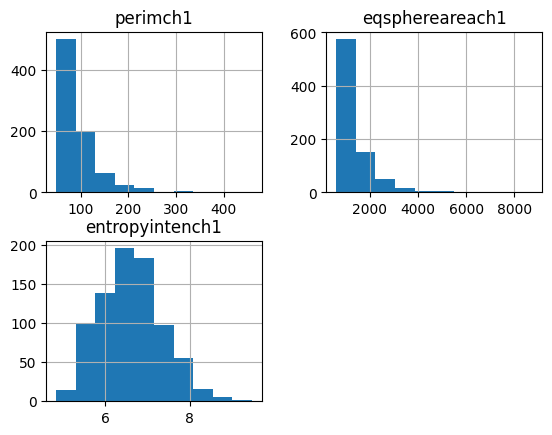

In [9]:
#analisis univariado es donde vemos la forma de la distribucion de cada variable
df_train.hist()
plt.show()

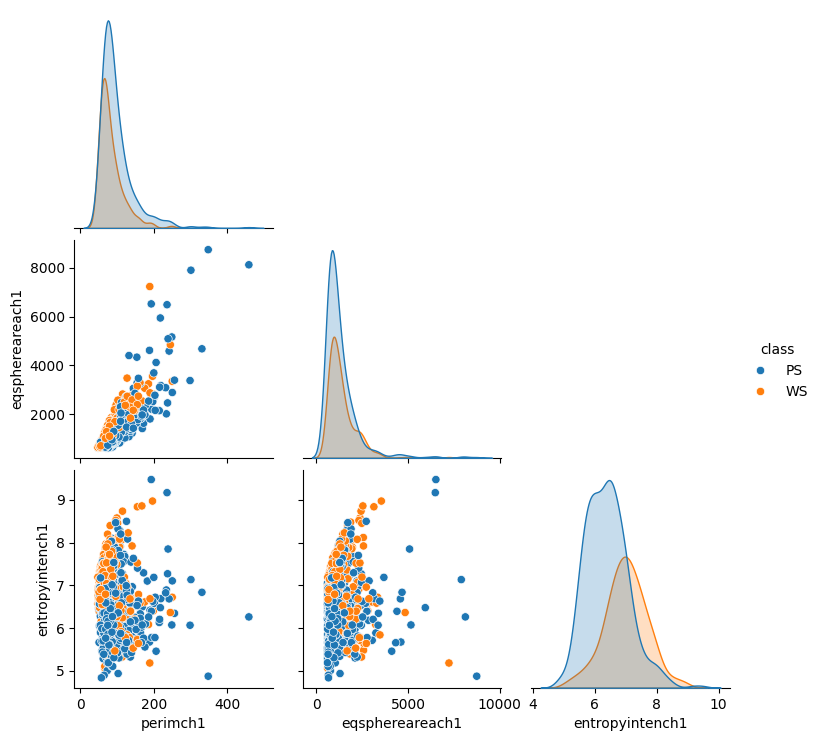

In [10]:
#analisis bivariado
#se usa hue porque hay una clasificacion porque son clases, vs la regresion que son continues ahi no usamos hue
sns.pairplot(data=df_train, hue= 'class', corner=True) 
plt.show()

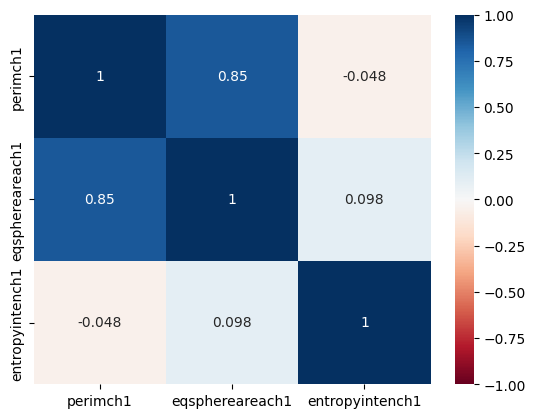

In [11]:
# Generar el mapa de calor con las correlaciones entre las variables numéricas
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()


### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [21]:
X_train = df_train[['entropyintench1','perimch1','eqsphereareach1']].copy()
y_train = df_train['class'].copy()
X_val = df_val[['entropyintench1','perimch1','eqsphereareach1']].copy()
y_val = df_val['class'].copy()
X_test = df_test[['entropyintench1','perimch1','eqsphereareach1']].copy()
y_test = df_test['class'].copy()

In [22]:
label_encoder = LabelEncoder() 
y_train_enc = label_encoder.fit_transform(y_train) #hace el ajuste transformacion y aprende cualquier parametro dentro de la transformacion
y_val_enc = label_encoder.transform(y_val) #hace la transformacion con el parametro aprendido
y_test_enc = label_encoder.transform(y_test) #hace la transformacion con el parametro aprendido
# me da error de dataconversion:
#       DataConversionWarning: A column-vector y was passed when a 1d array was expected. 
#       Please change the shape of y to (n_samples, ), for example using ravel().


# Encode the labels and reshape using ravel()
#y_train_enc = label_encoder.fit_transform(y_train.values.ravel())
#y_test_enc = label_encoder.transform(y_test.values.ravel())

# When you use ravel(), you're transforming your label data from a column vector (2D array) into a 1-dimensional array (1D array). 
# The LabelEncoder from sklearn expects the input labels to be a 1D array. 
# The transformation ensures that the data format is compatible with LabelEncoder.


In [23]:
y_train

103     PS
1745    WS
1363    PS
866     PS
1216    PS
        ..
520     WS
1737    PS
241     PS
684     PS
1646    WS
Name: class, Length: 807, dtype: category
Categories (2, object): ['PS', 'WS']

In [24]:
#vamos a hacer la tuberia
clf_tree_p = Pipeline([
    ("powertransform", PowerTransformer()),
    ("tree",DecisionTreeClassifier(random_state=2025,class_weight="balanced"))
])
clf_tree_cv = GridSearchCV(
    clf_tree_p,
    param_grid={
        "tree__max_depth":[3,5,7,9],
        "tree__min_samples_leaf":[1,3,5,7,9],
        "tree__min_samples_split":[2,4,6,8,10],
        "tree__criterion":["gini","entropy"]
    },
    cv=5,
    scoring="f1",
    n_jobs=-1
)

In [25]:
clf_tree_cv.fit(X_train,y_train_enc)
clf_tree_cv.best_params_

{'tree__criterion': 'entropy',
 'tree__max_depth': 9,
 'tree__min_samples_leaf': 9,
 'tree__min_samples_split': 2}

accuracy: 0.77
f1_score: 0.70
              precision    recall  f1-score   support

          PS       0.83      0.80      0.82       127
          WS       0.68      0.72      0.70        75

    accuracy                           0.77       202
   macro avg       0.76      0.76      0.76       202
weighted avg       0.78      0.77      0.77       202



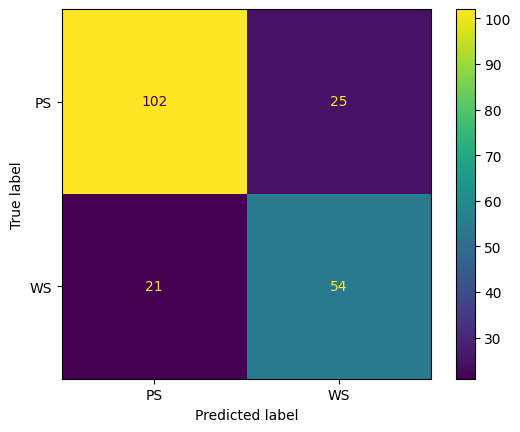

In [28]:
y_hat_val = clf_tree_cv.predict(X_val)
print(f'accuracy: {accuracy_score(y_val_enc,y_hat_val):.2f}')
print(f'f1_score: {f1_score(y_val_enc,y_hat_val):.2f}')
print(classification_report(y_val_enc,y_hat_val,target_names= label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_val_enc, y_hat_val, display_labels= label_encoder.classes_)
plt.show()

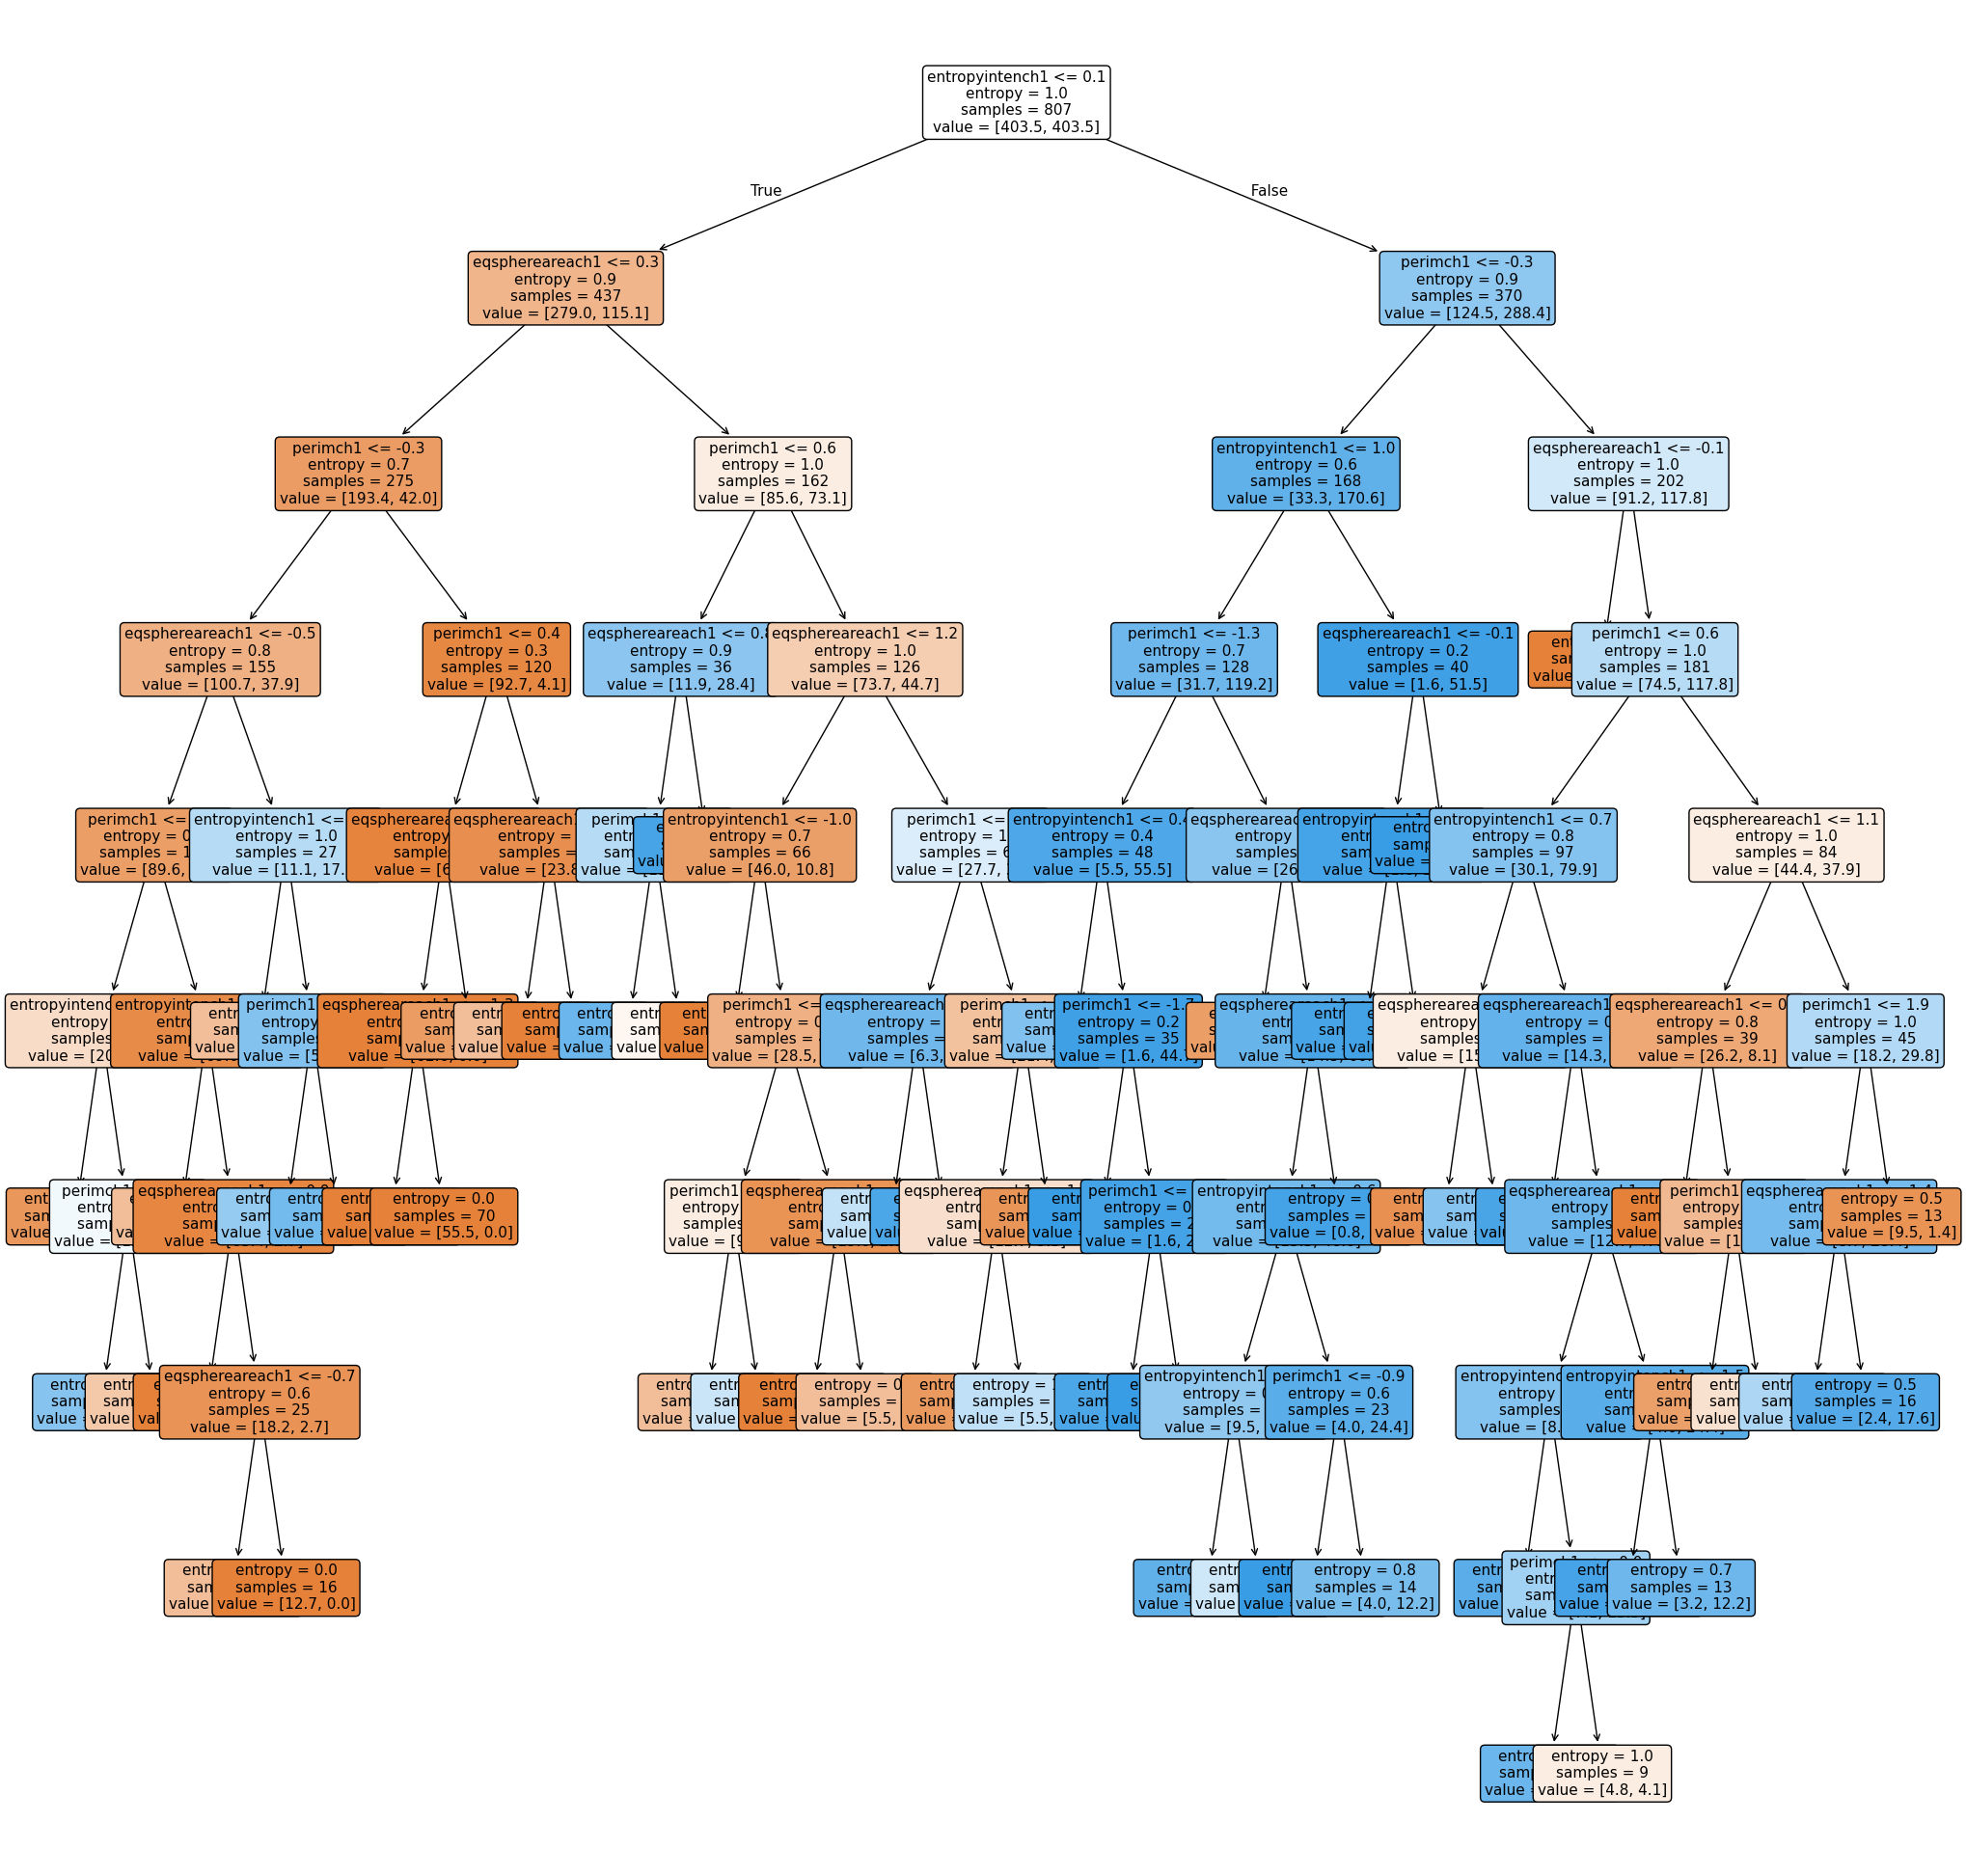

In [35]:
plt.figure(figsize=[25,25])
plot_tree(clf_tree_cv.best_estimator_['tree'],filled=True,
          fontsize=11,feature_names=X_train.columns,rounded=True,precision=1)
plt.show()

## La curva ROC (Receiver Operating Characteristic) 
Es una herramienta utilizada para evaluar el rendimiento de un modelo de clasificación binaria. Mide la capacidad del modelo para distinguir entre las dos clases (positiva y negativa) y se basa en diferentes umbrales de decisión. Aquí te explico qué mide y cómo interpretar la curva ROC:

### Componentes de la Curva ROC:

1. **Tasa de Verdaderos Positivos (TPR) o Sensibilidad**:
   - Mide la proporción de positivos reales que son correctamente identificados por el modelo.
   

2. **Tasa de Falsos Positivos (FPR)**:
   - Mide la proporción de negativos reales que son incorrectamente identificados como positivos por el modelo.

   ### Interpretación de la Curva ROC:

- **Eje X (Tasa de Falsos Positivos - FPR)**: Representa la proporción de negativos mal clasificados como positivos.
- **Eje Y (Tasa de Verdaderos Positivos - TPR)**: Representa la proporción de positivos correctamente clasificados.

Cada punto en la curva ROC representa un par (FPR, TPR) correspondiente a un umbral de decisión específico. Al variar el umbral, se obtienen diferentes valores de FPR y TPR, formando la curva ROC.

### Área Bajo la Curva (AUC - Area Under the Curve):

- **AUC (Área Bajo la Curva)**: Es una métrica resumen de la curva ROC que mide la capacidad general del modelo para distinguir entre las clases.
  - **AUC = 1**: Indica un modelo perfecto que clasifica todas las instancias correctamente.
  - **AUC = 0.5**: Indica un modelo que no tiene capacidad de discriminación (equivalente a una clasificación aleatoria).
  - **AUC > 0.5**: Indica que el modelo tiene una capacidad de discriminación mejor que el azar.

### Ejemplo de Interpretación:

- **Curva ROC**: Si la curva ROC está más cerca del vértice superior izquierdo, significa que el modelo tiene un buen rendimiento en la clasificación, con alta TPR y baja FPR.
- **AUC**: Un AUC cercano a 1 indica que el modelo tiene una excelente capacidad para distinguir entre las clases positivas y negativas.

La curva ROC es especialmente útil cuando se tiene un dataset desbalanceado, ya que proporciona una visión completa del rendimiento del modelo en diferentes umbrales de decisión.

Espero que esto aclare qué mide la curva ROC y cómo interpretarla. Si tienes más preguntas o necesitas más detalles, ¡estaré encantado de ayudarte!

<Figure size 2000x1000 with 0 Axes>

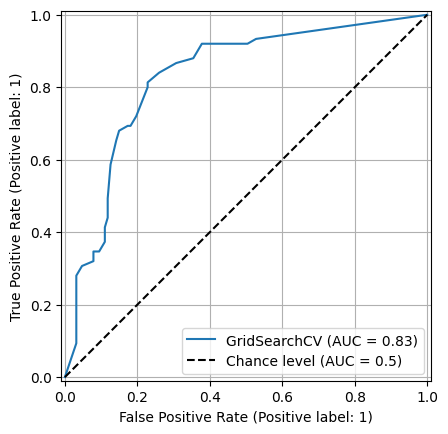

In [36]:

plt.figure(figsize=(20, 10))  # Ajusta estos valores para cambiar el tamaño del gráfico

# Generar la curva ROC
# la curva roc indica la capacidad del modelo
# mide la tasa de recall vs la tasa de falsos positivos
RocCurveDisplay.from_estimator(
    clf_tree_cv, X_val, y_val_enc, plot_chance_level=True
)

# Ajustar el tamaño de la fuente para el gráfico
plt.rcParams.update({'font.size': 10})  # Ajusta este valor para cambiar el tamaño de la fuente

plt.grid(True)
plt.show()

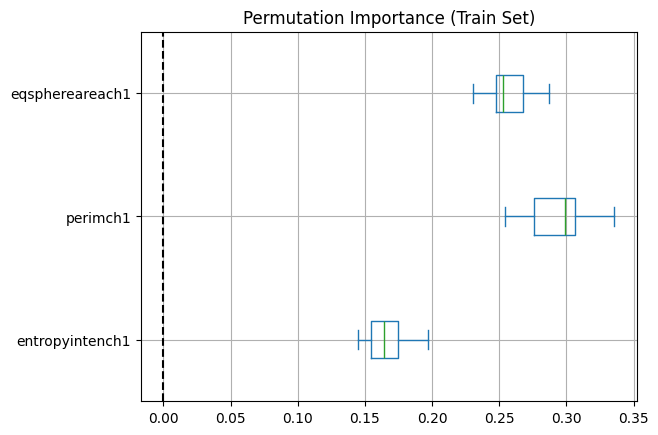

In [40]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

importance = permutation_importance(clf_tree_cv, X_train, y_train_enc, n_repeats=25, random_state=2025)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)

ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_title('Permutation Importance (Train Set)')
ax.grid(True)

plt.show()


In [41]:
y_hat_test = clf_tree_cv.predict(X_test)
print(f'accuracy: {accuracy_score(y_test_enc,y_hat_test):.2f}')
print(f'f1_score: {f1_score(y_test_enc,y_hat_test):.2f}')

accuracy: 0.76
f1_score: 0.69
